# Linear Filter
Author: Chul Min Yeum  
Email: cmyeum@uwaterloo.ca  

Last updated: 2024-02-06

## Table of Contents
* Low vs High Frequency
* Frequency Image (Simple Pattern)
* Frequency Image
* Computation of Cross Correlation 
* Identical Filter
* Shifting Filter
* Blurring Filter
* Shapening Filter
* Understanding of a Sharpening Filter (1D Example)
* Understanding of a Sharpening Filter (2D Example)
* Gaussian Kernel
* Gaussian Filters
* Gaussian Vs Box Filters
* Image Resizing (Aliasing)

## Low vs High Frequency

$$ x(t) = \sum_{n=0}^{\infty} \frac{2}{n\pi} (1 - \cos(n\pi))\sin\left(\frac{2\pi nt}{T_p}\right) $$

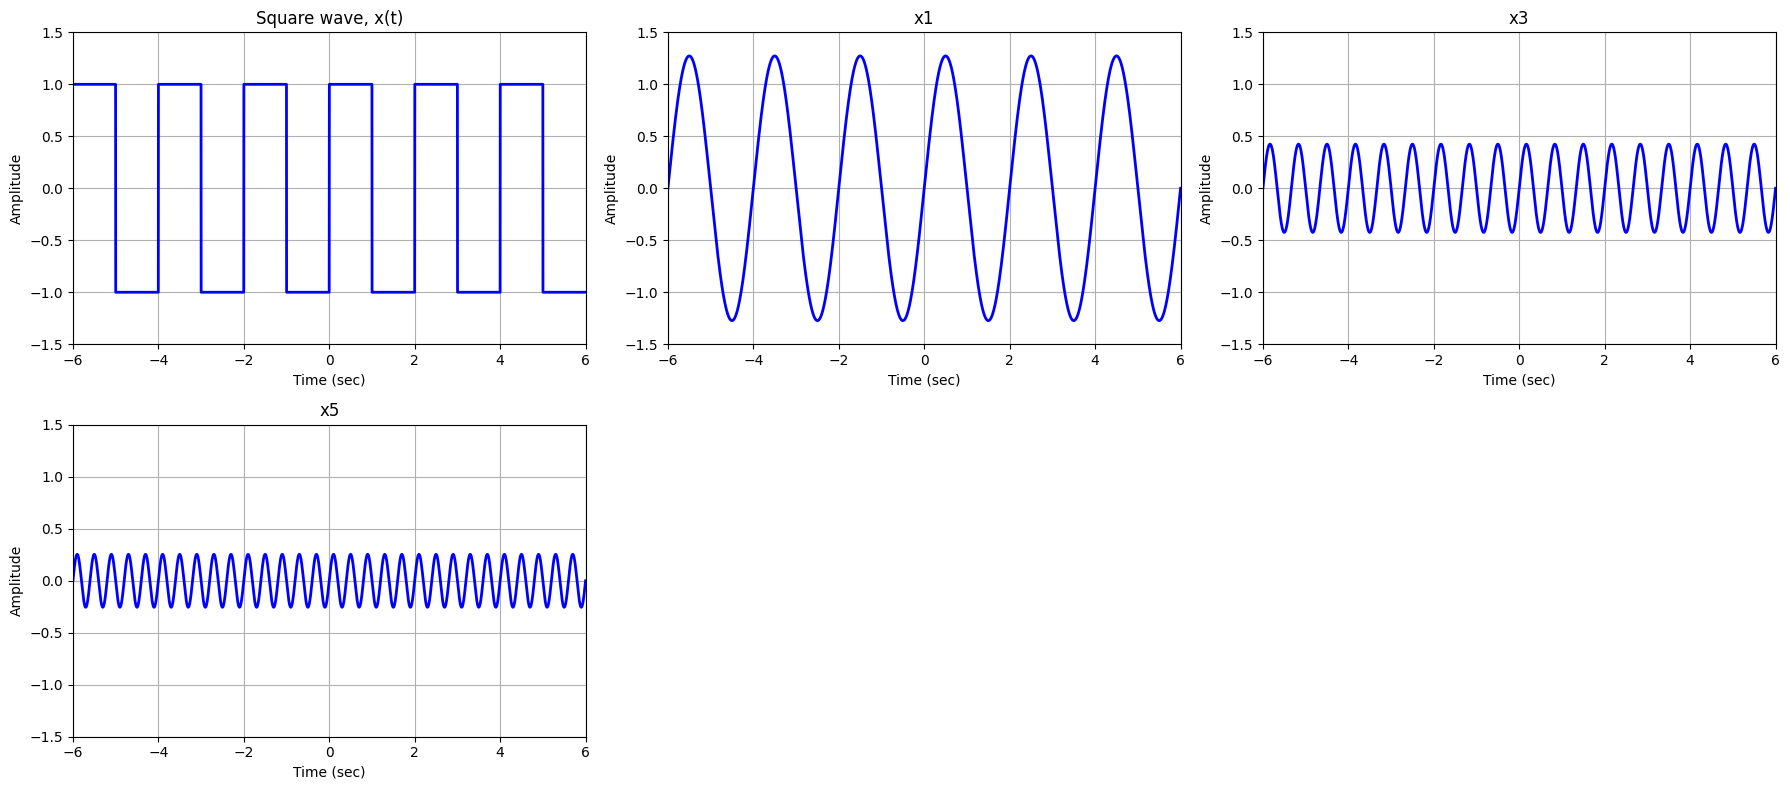

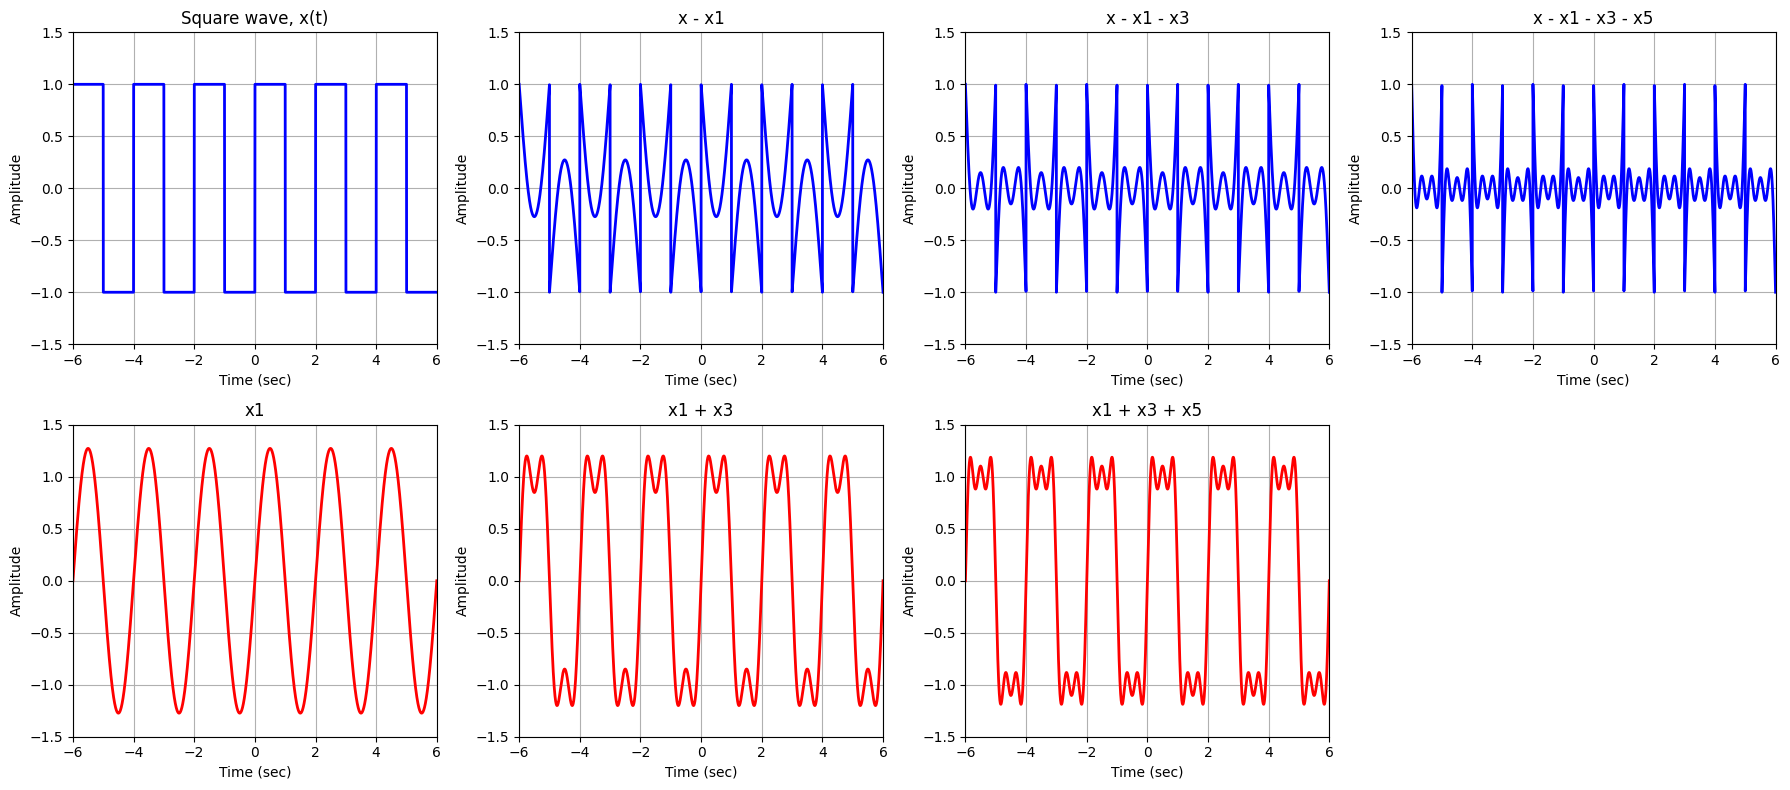

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
ncyle = 3
Fsa = 1000
Tp = 2
t = np.linspace(-ncyle*Tp, ncyle*Tp, int(2*ncyle*Tp*Fsa + 1))
x = lambda t: np.sign(np.sin(2*np.pi*t/Tp))
nCoeff = 5

# Fourier series terms
sig_y_analytic = np.zeros((nCoeff, len(t)))
for ii in range(1, nCoeff+1, 2):  # Odd harmonics only
    sig_y_analytic[ii-1,:] = 2/(ii*np.pi)*(1-np.cos(ii*np.pi))*np.sin(2*np.pi*ii*t/Tp)

# Plotting
plt.figure(figsize=(18,8))

# Plot original signal
plt.subplot(2,3,1)
plt.plot(t, x(t), '-b', linewidth=2)
plt.title('Square wave, x(t)')
plt.ylim([-1.5, 1.5])
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)

# Plot waves with diferent frequencies
for idx, ii in enumerate([1, 3, 5], start=2):
    plt.subplot(2, 3, idx)
    plt.plot(t, sig_y_analytic[ii-1,:], '-b', linewidth=2)
    plt.title(f"x{ii}")
    plt.ylim([-1.5, 1.5])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(18,8))

# Plot original signal
plt.subplot(2,4,1)
plt.plot(t, x(t), '-b', linewidth=2)
plt.title('Square wave, x(t)')
plt.ylim([-1.5, 1.5])
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)

# Plot errors and approximations
for idx, ii in enumerate([1, 3, 5], start=2):
    plt.subplot(2, 4, idx)
    plt.plot(t, x(t)-np.sum(sig_y_analytic[:ii,:], axis=0), '-b', linewidth=2)
    plt.title(f"x - {' - '.join(['x' + str(j) for j in range(1, ii+1, 2)])}")
    plt.ylim([-1.5, 1.5])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid(True)

for idx, ii in enumerate([1, 3, 5], start=5):
    plt.subplot(2, 4, idx)
    plt.plot(t, np.sum(sig_y_analytic[:ii,:], axis=0), '-r', linewidth=2)
    plt.title(f"{' + '.join(['x' + str(j) for j in range(1, ii+1, 2)])}")
    plt.ylim([-1.5, 1.5])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid(True)

plt.tight_layout()
plt.show()

## Frequency Image (Simple Pattern)

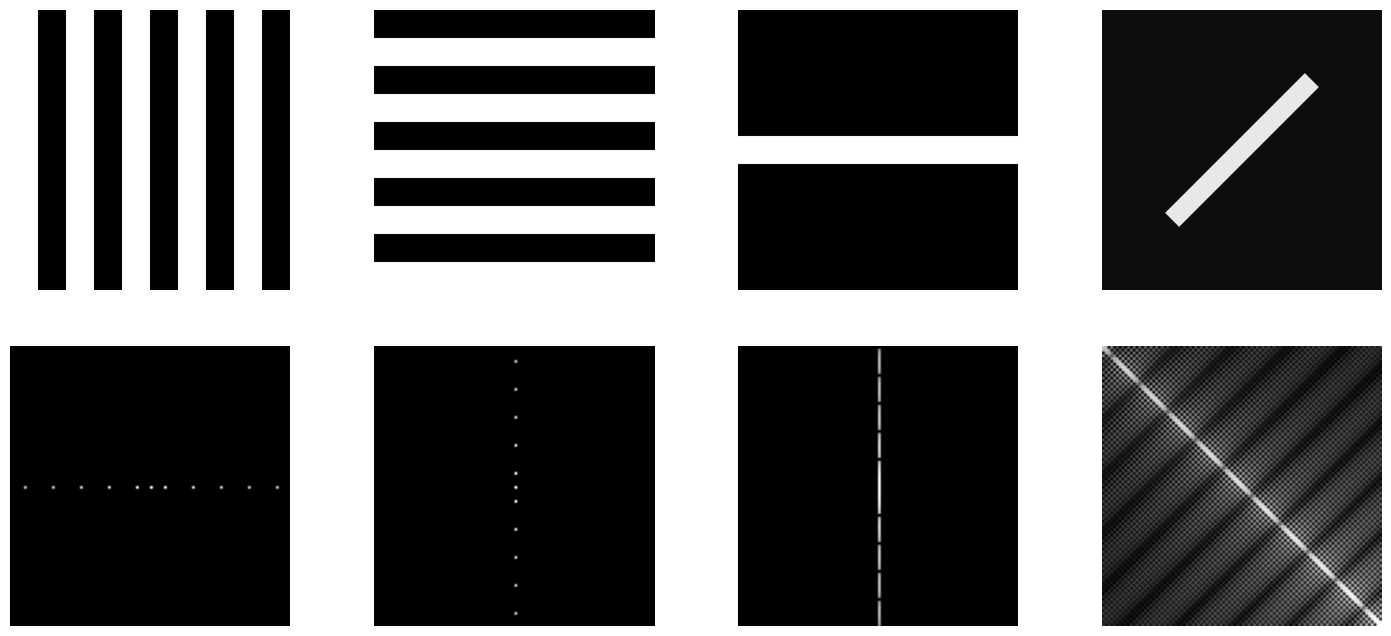

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Horizontal pattern
img_hp = np.tile(np.repeat([1, 0], 40), (400, 5))
imgf = np.fft.fftshift(np.fft.fft2(img_hp))
log_imgf = np.log(np.abs(imgf) + 1)
img_hpf = (log_imgf - log_imgf.min()) / (log_imgf.max() - log_imgf.min())

# Vertical pattern
img_vp = np.rot90(img_hp)
imgf = np.fft.fftshift(np.fft.fft2(img_vp))
log_imgf = np.log(np.abs(imgf) + 1)
img_vpf = (log_imgf - log_imgf.min()) / (log_imgf.max() - log_imgf.min())

# Horizontal bar
img_hb = np.zeros((400, 400))
img_hb[180:220, :] = 1
imgf = np.fft.fftshift(np.fft.fft2(img_hb))
log_imgf = np.log(np.abs(imgf) + 1)
img_hbf = (log_imgf - log_imgf.min()) / (log_imgf.max() - log_imgf.min())

# Diagonal bar
img_db = rotate(img_hb, angle=45)
imgf = np.fft.fftshift(np.fft.fft2(img_db))
log_imgf = np.log(np.abs(imgf) + 1)
img_dbf = (log_imgf - log_imgf.min()) / (log_imgf.max() - log_imgf.min())

# Plotting
plt.figure(1, figsize=(18,8))
plt.subplot(241); plt.imshow(img_hp, cmap='gray'); plt.axis('off')
plt.subplot(242); plt.imshow(img_vp, cmap='gray'); plt.axis('off')
plt.subplot(243); plt.imshow(img_hb, cmap='gray'); plt.axis('off')
plt.subplot(244); plt.imshow(img_db, cmap='gray'); plt.axis('off')
plt.subplot(245); plt.imshow(img_hpf[150:250, 150:250], cmap='gray'); plt.axis('off')
plt.subplot(246); plt.imshow(img_vpf[150:250, 150:250], cmap='gray'); plt.axis('off')
plt.subplot(247); plt.imshow(img_hbf[150:250, 150:250], cmap='gray'); plt.axis('off')
plt.subplot(248); plt.imshow(img_dbf[150:250, 150:250], cmap='gray'); plt.axis('off')
plt.show()


## Frequency Image

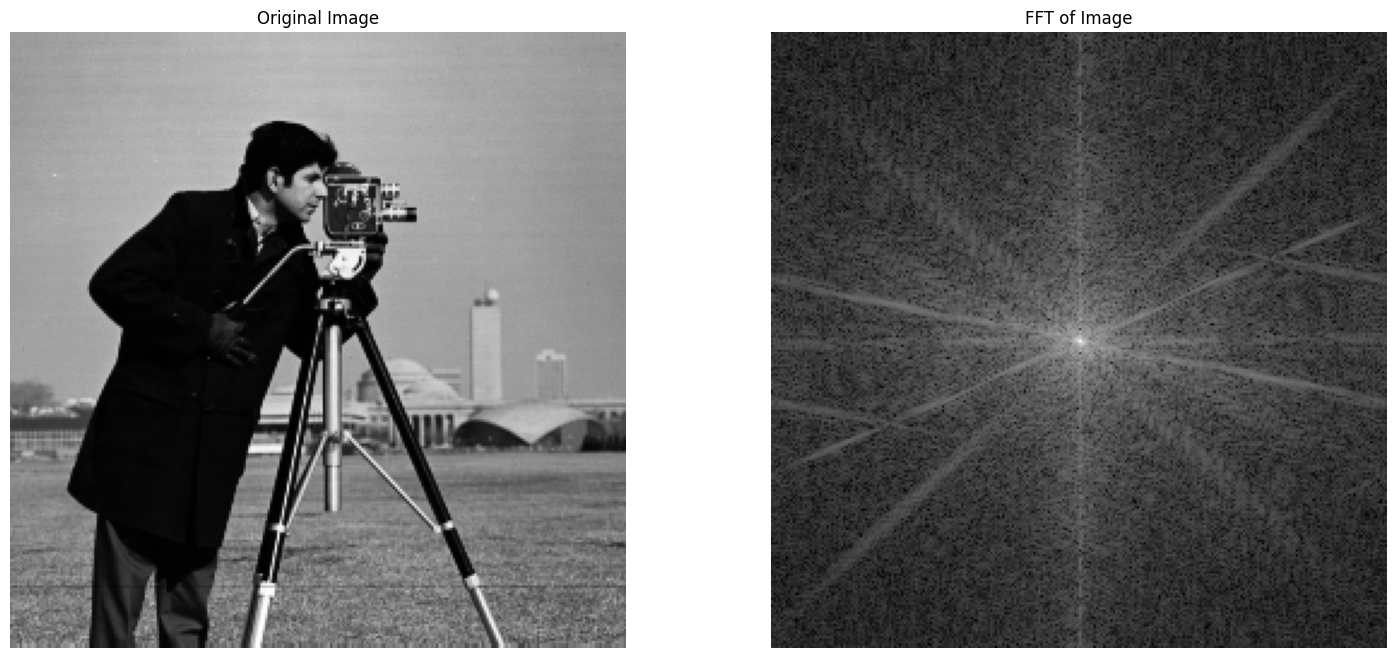

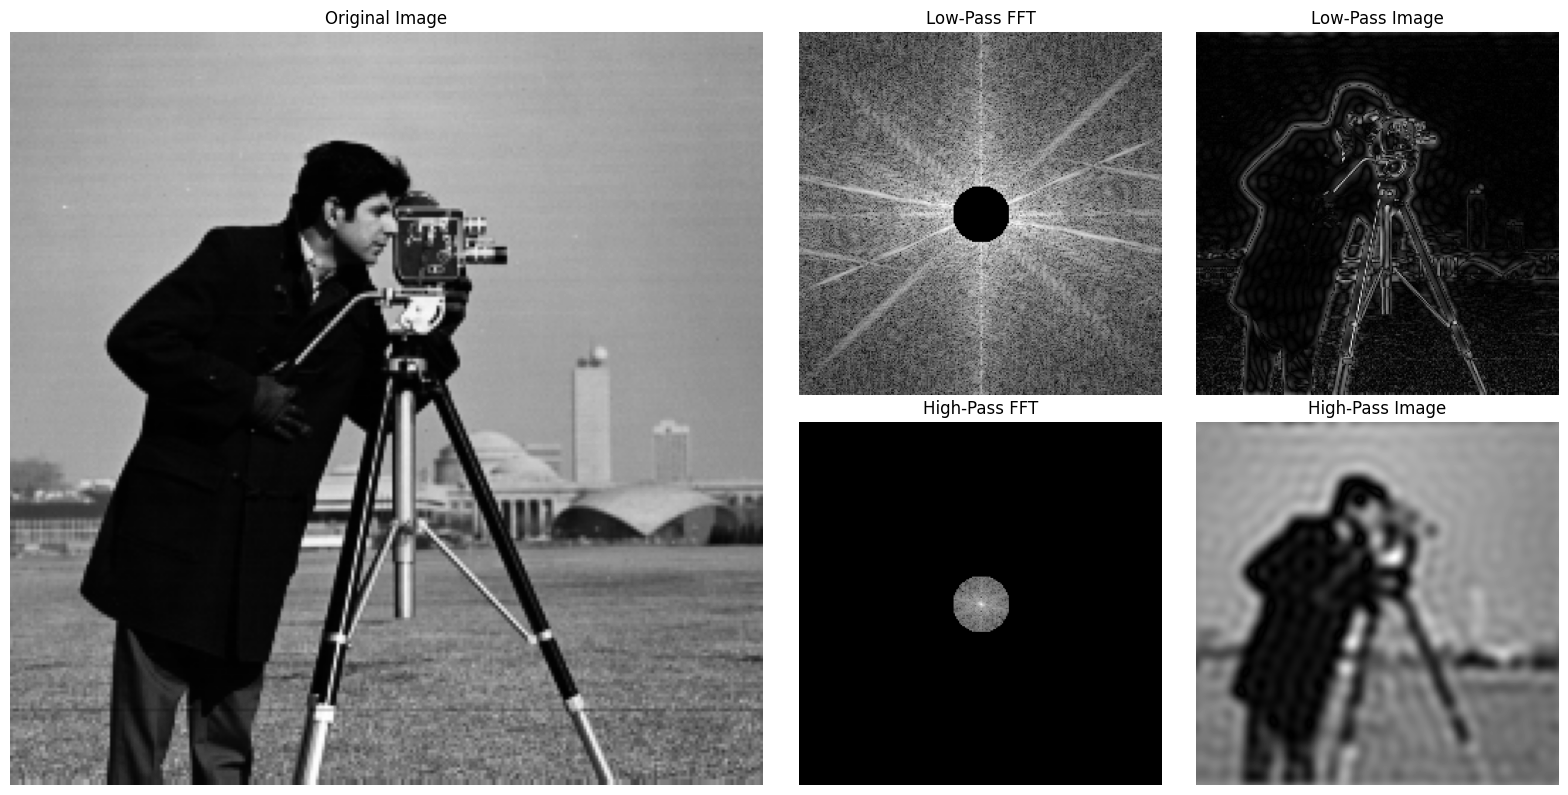

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import io, img_as_float

# Load the image
img = io.imread('cameraman.tif')
img = img_as_float(img)

# Compute 2D Fourier transform and shift zero frequency component to center
imgf = fftshift(fft2(img))
imgf_display = np.log(np.abs(imgf) + 1)

# Create a figure and set its size
fig1 = plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(img, cmap='gray'); plt.axis('off')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(imgf_display, cmap='gray'); plt.axis('off')
plt.title('FFT of Image')

# Create a binary mask for frequency filtering
mask = np.ones(img.shape)
Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
center = np.array(img.shape) // 2
c_sz = 20
mask = ((X - center[1]) ** 2 + (Y - center[0]) ** 2) < c_sz ** 2

# Low-pass filter: Zero out frequencies inside the circle
imgf_low = imgf.copy()
imgf_low[mask] = 0
img_low = ifft2(ifftshift(imgf_low))

# High-pass filter: Zero out frequencies outside the circle
imgf_high = imgf.copy()
imgf_high[~mask] = 0
img_high = ifft2(ifftshift(imgf_high))

# Create another figure for displaying results of frequency filtering
fig2 = plt.figure(figsize=(16,8))
plt.subplot(2, 4, (1, 6))
plt.imshow(img, cmap='gray')
plt.title('Original Image'); plt.axis('off')
plt.subplot(2,4,3)
plt.imshow(np.log(np.abs(imgf_low) + 1), cmap='gray')
plt.title('Low-Pass FFT'); plt.axis('off')
plt.subplot(2,4,4)
plt.imshow(np.abs(img_low), cmap='gray')
plt.title('Low-Pass Image'); plt.axis('off')
plt.subplot(2,4,7)
plt.imshow(np.log(np.abs(imgf_high) + 1), cmap='gray')
plt.title('High-Pass FFT'); plt.axis('off')
plt.subplot(2,4,8)
plt.imshow(np.abs(img_high), cmap='gray')
plt.title('High-Pass Image'); plt.axis('off')

plt.tight_layout()
plt.show()


## Computation of Cross Correlation 

Run the [**code**](comp_cross_corrleation.m) at MATLAB

## Identical Filter

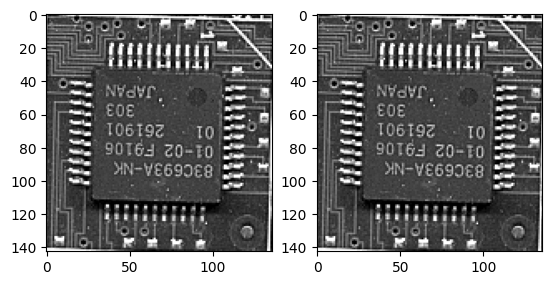

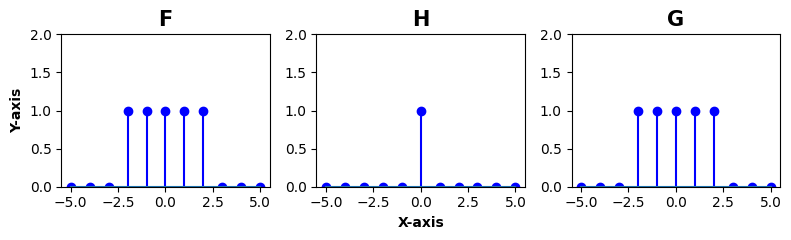

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.signal import convolve2d

# Load image and extract patch
img = io.imread('board.tif')
bbox = (7.51, 152.51, 135.98, 142.98)  # Format: (xmin, ymin, width, height)
patch = color.rgb2gray(img[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])])

# Create 3x3 kernel
k1 = np.zeros((3, 3))
k1[1, 1] = 1

# Display patch and convolution result
plt.figure(11)
plt.subplot(121)
plt.imshow(patch, cmap='gray')
plt.subplot(122)
plt.imshow(convolve2d(patch, k1, mode='same'), cmap='gray')
plt.show()

# Create F, H, and G signals for demonstration
x = np.arange(-5, 6)
F = np.zeros_like(x); F[3:8] = 1
H = np.zeros_like(x); H[5] = 1
G = np.convolve(F, H, mode='same')

# Display F, H, and G
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
ax1.stem(x, F, linefmt='-b', markerfmt='ob', basefmt='-')
ax1.set_title('F', fontweight='bold', fontsize=15)
ax1.set_ylim([0, 2])
ax2.stem(x, H, linefmt='-b', markerfmt='ob', basefmt='-')
ax2.set_title('H', fontweight='bold', fontsize=15)
ax2.set_ylim([0, 2])
ax2.set_xlabel('X-axis', fontweight='bold')
ax3.stem(x, G, linefmt='-b', markerfmt='ob', basefmt='-')
ax3.set_title('G', fontweight='bold', fontsize=15)
ax3.set_ylim([0, 2])
ax1.set_ylabel('Y-axis', fontweight='bold')
plt.tight_layout()
plt.show()


## Shifting Filter

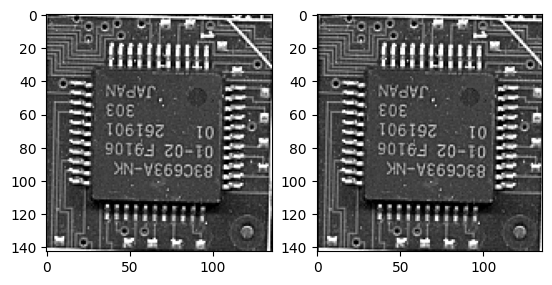

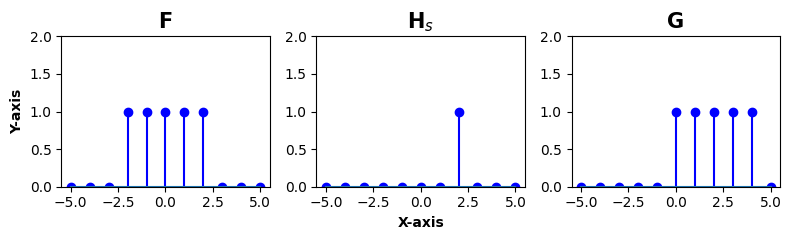

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from scipy.signal import convolve2d

# Load image and extract patch
img = io.imread('board.tif')
bbox = (7.51, 152.51, 135.98, 142.98)  # Format: (xmin, ymin, width, height)
patch = img_as_float(color.rgb2gray(img[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]))

# Create 3x3 kernel with a value of 1 in the position (2, 3)
k1 = np.zeros((3, 3))
k1[1, 2] = 1

# Display patch and convolution result
plt.figure(11)
plt.subplot(121)
plt.imshow(patch, cmap='gray')
plt.subplot(122)
plt.imshow(convolve2d(patch, k1, mode='same'), cmap='gray')
plt.show()

# Create F, H, and G signals for demonstration
x = np.arange(-5, 6)
F = np.zeros_like(x); F[3:8] = 1
H = np.zeros_like(x); H[7] = 1
G = np.convolve(F, H, mode='same')

# Display F, H, and G
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
ax1.stem(x, F, linefmt='-b', markerfmt='ob', basefmt='-')
ax1.set_title('F', fontweight='bold', fontsize=15)
ax1.set_ylim([0, 2])
ax2.stem(x, H, linefmt='-b', markerfmt='ob', basefmt='-')
ax2.set_title('H$_s$', fontweight='bold', fontsize=15)
ax2.set_ylim([0, 2])
ax2.set_xlabel('X-axis', fontweight='bold')
ax3.stem(x, G, linefmt='-b', markerfmt='ob', basefmt='-')
ax3.set_title('G', fontweight='bold', fontsize=15)
ax3.set_ylim([0, 2])
ax1.set_ylabel('Y-axis', fontweight='bold')
fig2.tight_layout()
fig2.set_size_inches(8, 2.5)
plt.show()


## Blurring Filter

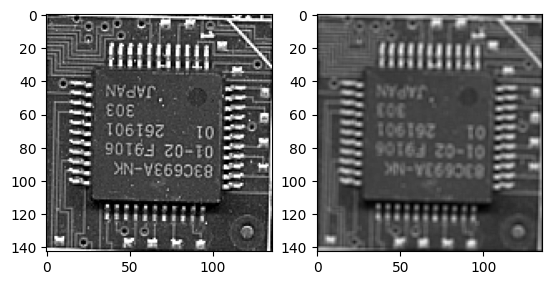

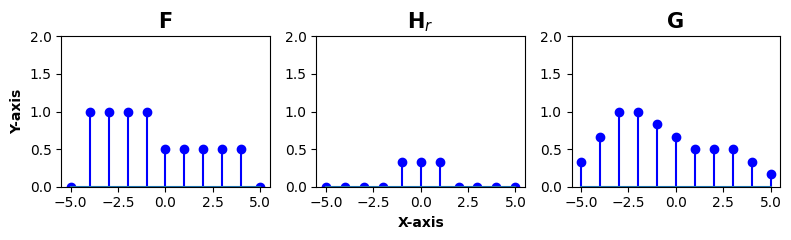

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from scipy.signal import convolve2d

# Load image and extract patch
img = io.imread('board.tif')
bbox = (7.51, 152.51, 135.98, 142.98)  # Format: (xmin, ymin, width, height)
patch = img_as_float(color.rgb2gray(img[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]))

# Create 3x3 averaging kernel
k1 = np.ones((3, 3)) / 9

# Display patch and convolution result
plt.figure(11)
plt.subplot(121)
plt.imshow(patch, cmap='gray')
plt.subplot(122)
plt.imshow(convolve2d(patch, k1, mode='same'), cmap='gray')
plt.show()

# Create F, H, and G signals for demonstration
x = np.arange(-5, 6, dtype=float)
F = np.zeros_like(x); F[1:5] = 1; F[5:-1] = 0.5
H = np.zeros_like(x); H[4:7] = 1/3
G = np.convolve(F, H, mode='same')

# Display F, H, and G
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
ax1.stem(x, F, linefmt='-b', markerfmt='ob', basefmt='-')
ax1.set_title('F', fontweight='bold', fontsize=15)
ax1.set_ylim([0, 2])
ax2.stem(x, H, linefmt='-b', markerfmt='ob', basefmt='-')
ax2.set_title('H$_r$', fontweight='bold', fontsize=15)
ax2.set_ylim([0, 2])
ax2.set_xlabel('X-axis', fontweight='bold')
ax3.stem(x, G, linefmt='-b', markerfmt='ob', basefmt='-')
ax3.set_title('G', fontweight='bold', fontsize=15)
ax3.set_ylim([0, 2])
ax1.set_ylabel('Y-axis', fontweight='bold')
fig2.tight_layout()
fig2.set_size_inches(8, 2.5)
plt.show()


## Shapening Filter

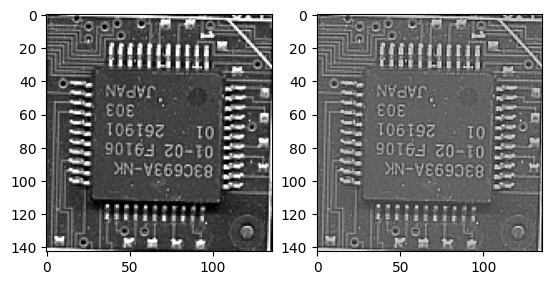

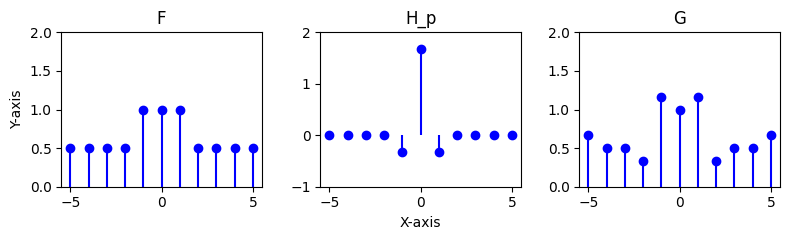

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Kernel Creation
k1 = np.zeros((3,3))
k1[1,1] = 2
k1 -= np.ones((3,3)) / 9

# Assuming 'patch' is a given 2D array, you'll visualize it here
plt.figure(11)
plt.subplot(121)
plt.imshow(patch, cmap='gray')
plt.subplot(122)
plt.imshow(convolve2d(patch, k1, mode='same'), cmap='gray')
plt.show()

# Signal Convolution
x = np.arange(-5, 6, dtype=float)
F = np.ones_like(x)
F[:4] = 0.5
F[-4:] = 0.5
H = np.zeros_like(x)
H[4] = -1/3
H[5] = 5/3
H[6] = -1/3
G = np.convolve(F, H, mode='same')

# Plotting signals
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,2.5))

ax1.stem(x, F, linefmt='-b', markerfmt='ob', basefmt=' ')
ax1.set_ylim([0, 2])
ax1.set_title('F')
ax1.set_ylabel('Y-axis')

ax2.stem(x, H, linefmt='-b', markerfmt='ob', basefmt=' ')
ax2.set_ylim([-1, 2])
ax2.set_title('H_p')
ax2.set_xlabel('X-axis')

ax3.stem(x, G, linefmt='-b', markerfmt='ob', basefmt=' ')
ax3.set_ylim([0, 2])
ax3.set_title('G')

plt.tight_layout()
plt.show()

## Understanding of a Sharpening Filter (1D Example)

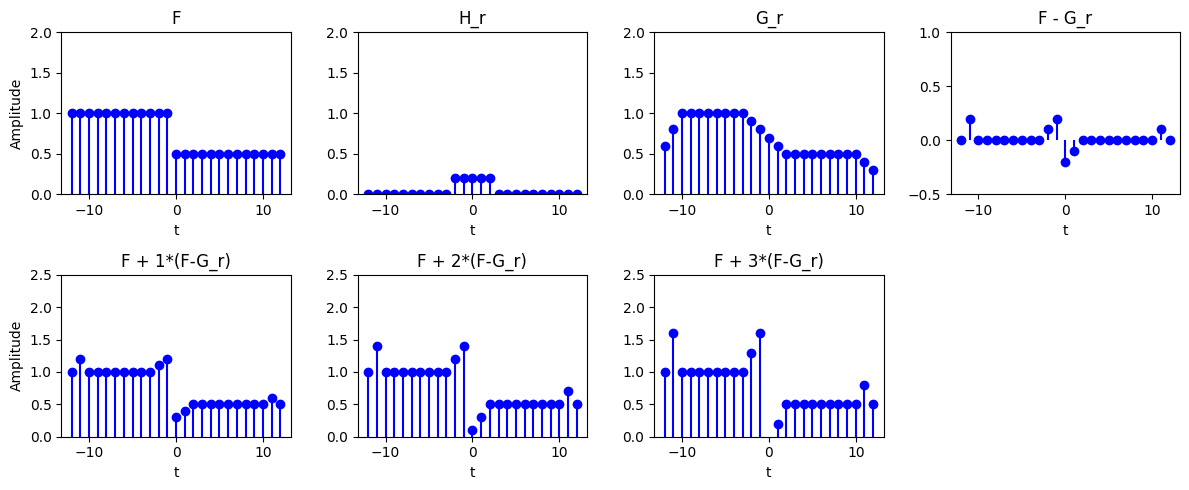

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define x
x = np.arange(-12, 13, dtype=float)

# Define F and H signals
F = np.zeros_like(x)
F[:12] = 1
F[12:] = 0.5

H = np.zeros_like(x)
H[10:15] = 1/5

# Convolve F and H
G = np.convolve(F, H, mode='same')

# Compute F-G
F_G = F - G
F_G[0] = 0
F_G[-1] = 0

# Set up figure
fig, axs = plt.subplots(2, 4, figsize=(12, 5))

# Plot F
axs[0, 0].stem(x, F, linefmt='-b', markerfmt='ob', basefmt=' ')
axs[0, 0].set_ylim([0, 2])
axs[0, 0].set_title('F')
axs[0, 0].set_xlabel('t')
axs[0, 0].set_ylabel('Amplitude')

# Plot H
axs[0, 1].stem(x, H, linefmt='-b', markerfmt='ob', basefmt=' ')
axs[0, 1].set_ylim([0, 2])
axs[0, 1].set_title('H_r')
axs[0, 1].set_xlabel('t')

# Plot G
axs[0, 2].stem(x, G, linefmt='-b', markerfmt='ob', basefmt=' ')
axs[0, 2].set_ylim([0, 2])
axs[0, 2].set_title('G_r')
axs[0, 2].set_xlabel('t')

# Plot F-G
axs[0, 3].stem(x, F_G, linefmt='-b', markerfmt='ob', basefmt=' ')
axs[0, 3].set_ylim([-0.5, 1])
axs[0, 3].set_title('F - G_r')
axs[0, 3].set_xlabel('t')

# Plot F+alpha*F_G for different alpha values
alphas = [1, 2, 3]
for i, alpha in enumerate(alphas):
    axs[1, i].stem(x, F + alpha*F_G, linefmt='-b', markerfmt='ob', basefmt=' ')
    axs[1, i].set_ylim([0, 2.5])
    axs[1, i].set_title(f'F + {alpha}*(F-G_r)')
    axs[1, i].set_xlabel('t')
    if i == 0:
        axs[1, i].set_ylabel('Amplitude')

axs[1, 3].remove()

plt.tight_layout()
plt.show()


## Understanding of a Sharpening Filter (2D Example)

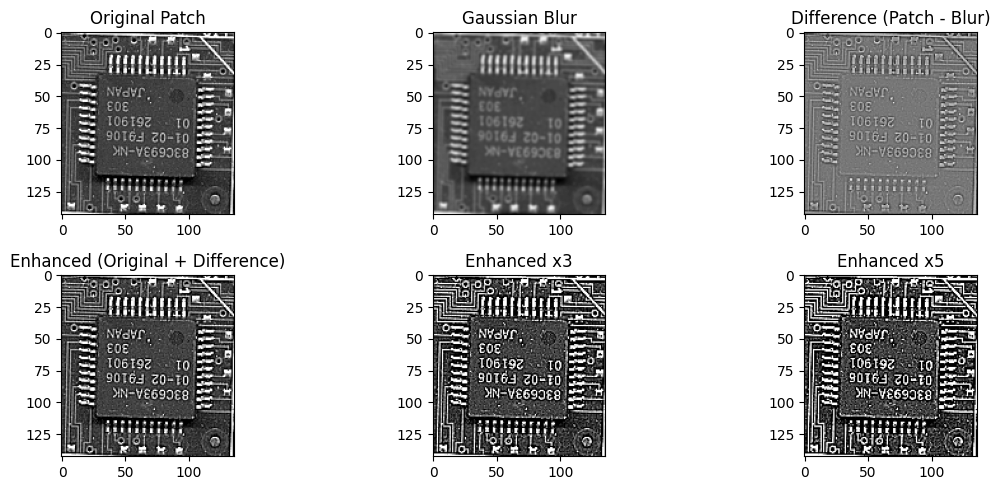

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, filters, exposure
from scipy.signal import convolve2d

# Load image and extract patch
img = io.imread('board.tif')
bbox = (7.51, 152.51, 135.98, 142.98)  # Format: (xmin, ymin, width, height)
patch = img_as_float(color.rgb2gray(img[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]))

# Define kernel k1
k1 = np.zeros((3, 3))
k1[1, 1] = 2
k1 = k1 - np.ones((3, 3)) / 9

# Displaying the results
fig1 = plt.figure(1, figsize=(12, 5))

plt.subplot(231)
plt.imshow(patch, cmap='gray')
plt.title('Original Patch')

# Gaussian blur
G = filters.gaussian(patch, sigma=1)

plt.subplot(232)
plt.imshow(G, cmap='gray')
plt.title('Gaussian Blur')

# Difference between the patch and its blurred version
patch_G = patch - G

plt.subplot(233)
plt.imshow(patch_G, cmap='gray')
plt.title('Difference (Patch - Blur)')

plt.subplot(234)
plt.imshow(np.clip(patch + patch_G, 0, 1), cmap='gray')
plt.title('Enhanced (Original + Difference)')

plt.subplot(235)
plt.imshow(np.clip(patch + 3*patch_G, 0, 1), cmap='gray')
plt.title('Enhanced x3')

plt.subplot(236)
plt.imshow(np.clip(patch + 5*patch_G, 0, 1), cmap='gray')
plt.title('Enhanced x5')

plt.tight_layout()
plt.show()


## Gaussian Kernel

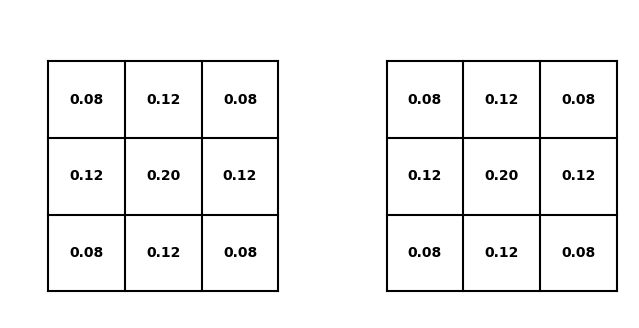

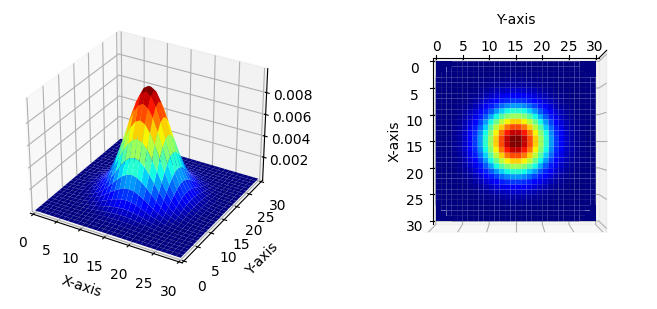

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def gaussian_2d(x, y, sigma=1.0):
    return (1.0 / (2 * np.pi * sigma**2)) * np.exp(- (x**2 + y**2) / (2 * sigma**2))

def plot_mat(matrix, ax, num_type='float'):
    c, r = matrix.shape
    white_cmap = plt.cm.colors.ListedColormap(['white'])
    ax.imshow(matrix, cmap=white_cmap)

    for ii in range(c + 1):
        ax.plot([0, r], [ii, ii], color='k', linewidth=1.5)
    for ii in range(r + 1):
        ax.plot([ii, ii], [0, c], color='k', linewidth=1.5)
        
    if num_type == 'integer':
        text_strings = np.char.mod('%d', matrix)
    else:
        text_strings = np.char.mod('%3.2f', matrix)

    for i in range(c):
        for j in range(r):
            ax.text(j+0.5, i+0.5, text_strings[i, j], ha='center', va='center', fontsize=10, fontweight='bold')
    ax.set_xticks(np.arange(r))
    ax.set_yticks(np.arange(c))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    ax.axis('equal')

# MATLAB's fspecial('gaussian',3,1) equivalent in Python:
# https://stackoverflow.com/questions/47369579/how-to-get-the-gaussian-filter
h = cv2.getGaussianKernel(3, 1.0)
h = np.multiply(h.T, h)
h = h / h.sum()

num_size = 3
x, y = np.meshgrid(np.arange(1, num_size + 1), np.arange(1, num_size + 1))
x = x - (num_size // 2 + 1)
y = y - (num_size // 2 + 1)
sigma = 1.0

g_sigma = gaussian_2d(x, y, sigma)
g_sigma = g_sigma / g_sigma.sum()

fig1, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_mat(h, axs[0], 'float')
plot_mat(g_sigma, axs[1], 'float')


fig2 = plt.figure(figsize=(8, 3))
ax1 = fig2.add_subplot(1, 2, 1, projection='3d')
ax2 = fig2.add_subplot(1, 2, 2, projection='3d')

h_large = cv2.getGaussianKernel(31, 4)
h_large = np.multiply(h_large.T, h_large)
h_large = h_large / h_large.sum()

X, Y = np.meshgrid(np.arange(h_large.shape[1]), np.arange(h_large.shape[0]))

ax1.plot_surface(X, Y, h_large, cmap='jet')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_ylim3d(0, 30)
ax1.set_xlim3d(0, 30)

ax2.view_init(90, 0)
ax2.plot_surface(X, Y, h_large, cmap='jet')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_zticks([])
ax2.set_ylim3d(0, 30)
ax2.set_xlim3d(0, 30)

plt.tight_layout()
plt.show()


## Gaussian Filters

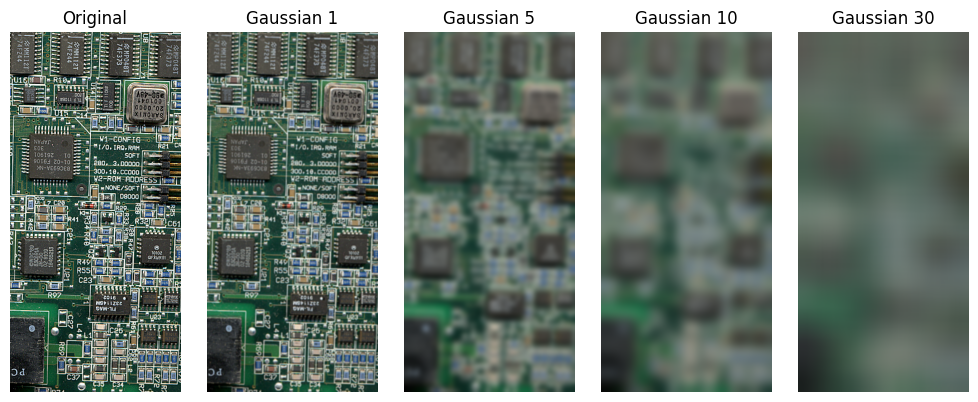

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread('board.tif', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format for visualization

# Crop the image
bbox = [152.51, 7.51, 142.98, 135.98]
patch = img[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]

# Define Gaussian filters using OpenCV's getGaussianKernel function
f1 = cv2.getGaussianKernel(101, 1) * cv2.getGaussianKernel(101, 1).T
f2 = cv2.getGaussianKernel(101, 5) * cv2.getGaussianKernel(101, 5).T
f3 = cv2.getGaussianKernel(101, 10) * cv2.getGaussianKernel(101, 10).T
f4 = cv2.getGaussianKernel(101, 30) * cv2.getGaussianKernel(101, 30).T

# Plot the images
plt.figure(figsize=(10, 4))
plt.subplot(151), plt.imshow(img), plt.title('Original'), plt.axis('off')
plt.subplot(152), plt.imshow(cv2.filter2D(img, -1, f1)), plt.title('Gaussian 1'), plt.axis('off')
plt.subplot(153), plt.imshow(cv2.filter2D(img, -1, f2)), plt.title('Gaussian 5'), plt.axis('off')
plt.subplot(154), plt.imshow(cv2.filter2D(img, -1, f3)), plt.title('Gaussian 10'), plt.axis('off')
plt.subplot(155), plt.imshow(cv2.filter2D(img, -1, f4)), plt.title('Gaussian 30'), plt.axis('off')

plt.tight_layout()
plt.show()


## Gaussian Vs Box Filters

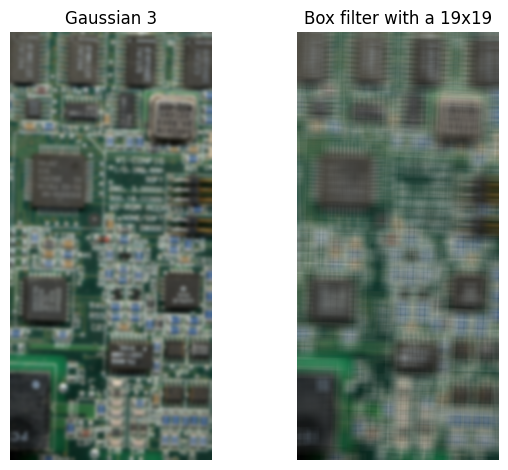

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread('board.tif', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format for visualization

# Crop the image
bbox = [152.51, 7.51, 142.98, 135.98]
patch = img[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]

# Add this after the previous Python code

# Define Gaussian filter using OpenCV's getGaussianKernel function
f1_gaussian = cv2.getGaussianKernel(19, 3) * cv2.getGaussianKernel(19, 3).T

# Define average filter
f2_average = np.ones((19, 19), dtype=np.float32) / 361  # 19*19 = 361

# Plot the images with the new filters applied
plt.figure(3)
plt.subplot(121), plt.imshow(cv2.filter2D(img, -1, f1_gaussian)), plt.title('Gaussian 3'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.filter2D(img, -1, f2_average)), plt.title('Box filter with a 19x19'), plt.axis('off')

plt.tight_layout()
plt.show()


## Image Resizing (Aliasing)

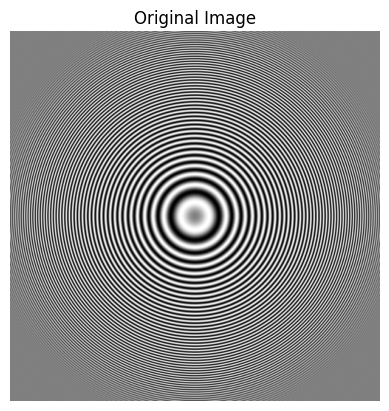

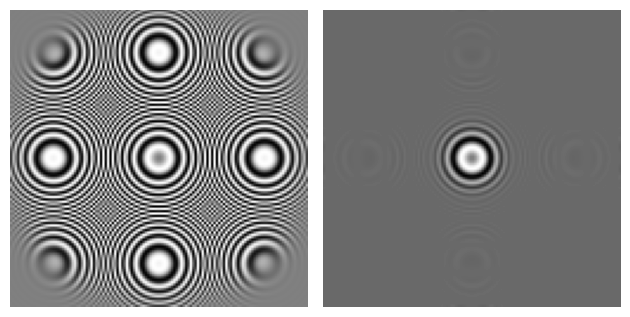

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def imzoneplate(N=501):
    """
    Create a zone plate test image.
    
    Parameters:
    - N: Size of the image. Default is 501.
    
    Returns:
    - I: N x N zone plate test image.
    """

    if N % 2 == 1:
        x2 = (N - 1) // 2
        x1 = -x2
    else:
        x2 = N // 2
        x1 = -x2 + 1

    x, y = np.meshgrid(np.arange(x1, x2+1), np.arange(x1, x2+1))
    r = np.hypot(x, y)
    
    km = 0.7 * np.pi
    rm = x2
    w = rm / 10
    term1 = np.sin((km * r**2) / (2 * rm))
    term2 = 0.5 * np.tanh((rm - r) / w) + 0.5
    g = term1 * term2

    I = (g + 1) / 2
    return I

    #   See also http://blogs.mathworks.com/steve/2011/07/19/jahne-test-pattern-take-3/
    
    #   Copyright 2012 The MathWorks, Inc.
    #   Steven L. Eddins

# Assuming you have a function that replicates the behavior of imzoneplate
Z = imzoneplate(501)

# Define Gaussian filter using OpenCV's getGaussianKernel function
fg = cv2.getGaussianKernel(15, 4) * cv2.getGaussianKernel(15, 4).T

# Display the original zone plate image
plt.figure(1)
plt.imshow(Z, cmap='gray')
plt.title('Original Image'), plt.axis('off')

# Subsample the image by a factor of 4
Z1 = Z[::4, ::4]

# Apply Gaussian filter and then subsample
Z2 = cv2.filter2D(Z, -1, fg)
Z2 = Z2[::4, ::4]

# Display the subsampled images
plt.figure(2)
plt.subplot(121), plt.imshow(Z1, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.imshow(Z2, cmap='gray'), plt.axis('off')

plt.tight_layout()
plt.show()
